## Introduction
The following notes show how to generate a re-usable dataset starting from files generated from openparlamento.it a few years back, and how to use this dataset to generate deep learning models that automatically classify a document (a parliament act).

This is a **multi-labels multi-classification** problem, as each document can be classified with more than one label. 

* The number of documents available is ~80k, they're stored in the ``opp_data/atti`` directory as files within a zipped archive, and csv files.
* A limited set (~1000) is extracted randomly and stored on S3 in ``.npz`` format.
* The label set is closed and amounts to many hundreds (~700).
* All functions used here are defined in the ``utils`` package, that needs to be imported at the beginning of the notebook.


## Creating a dataset
The following section shows how to generate a dataset for the Openparlamento tagged acts from raw data, and publish it to S3, for future usage in deep learning classifier.

The dataset extracts ``n_docs`` documents from the set and generates an ``.npz`` data-file and a ``.json`` vocabulary.

The dataset contains still *raw* textual data (text content and the taggings) and should be pre-processed and transformed into numerical *tensors* in order to be used in the deep learning models. See [Using a dataset](#Using-a-dataset) section, below.

In [10]:
import os
import sys
sys.path.append('..')

from dotenv import load_dotenv
import pandas as pd

from op.utils import preprocess_and_save_docs

# load secrets from local `.env` file
load_dotenv(verbose=False)

# this one function will do all
preprocess_and_save_docs(
    '../op/opp_data/atti/testi.zip', 'tagged_acts_16', 
    n_docs=1000, 
    tags_df=pd.read_csv('../op/opp_data/atti/tags.csv'), 
    tagging_df=pd.read_csv('../op/opp_data/atti/atti_tags.csv'),
    cache_path='../op/datasets',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY')

)

100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


Saving data into ../op/datasets/tagged_acts_16.npz
Uploading to s3://opp-datasets/tagged_acts_16.npz
Saving vocab into ../op/datasets/tagged_acts_16_vocab.json
Uploading to s3://opp-datasets/tagged_acts_16_vocab.json


(('https://opp-datasets.s3.eu-central-1.amazonaws.com/tagged_acts_16.npz',
  '4c3556727beb2c4cdd65813327d42b16'),
 ('https://opp-datasets.s3.eu-central-1.amazonaws.com/tagged_acts_16_vocab.json',
  '02826d2948bd04bddfb68e56f44b8ca8'))

## Using a dataset
The ``load_data_16`` function, loads a training set and a test set of texts with assigned labels. The test set has a default ratio of 0.2 (this can be changed with the ``test_split`` parameters).

In [52]:
import sys
sys.path.append('..')
from op.datasets import opp_tagged_acts
(train_texts_raw, train_labels_raw), (test_texts_raw, test_labels_raw) = opp_tagged_acts.load_data_16(test_split=0.25)

In [53]:
len(train_texts_raw), len(test_texts_raw)

(750, 250)

## Fetching the vocabulary
The *vocabulary* can be fetched with the ``load_vocab_16`` function that returns a ``collections.Counter``, so that the ``most_common`` method can be used to list the most common words.

This vocabulary still refers to the **raw** content in the documents.

It can be useful during the analysis phase, in order to understand the structure of the data, and whether the most common words should be removed from the documents before being processed by Keras.

In [54]:
vocab = opp_tagged_acts.load_vocab_16()

In [55]:
vocab.most_common(30)

[('articolo', 6082),
 ('legge', 4533),
 ('comma', 4403),
 ('stato', 3181),
 ('decreto', 2643),
 ('ministro', 2462),
 ('ministero', 2129),
 ('essere', 1883),
 ('d', 1806),
 ('attività', 1803),
 ('art', 1770),
 ('presente', 1576),
 ('seguenti', 1434),
 ('parte', 1432),
 ('autorità', 1424),
 ('cp', 1403),
 ('governo', 1400),
 ('presidente', 1391),
 ('cs', 1382),
 ('quali', 1340),
 ('europea', 1334),
 ('consiglio', 1277),
 ('servizi', 1276),
 ('euro', 1269),
 ('disposizioni', 1258),
 ('nazionale', 1207),
 ('fine', 1178),
 ('secondo', 1172),
 ('economia', 1156),
 ('commissione', 1155)]

In this case, it seems that the first 20 words does not help in conveying a meaningful sense (they are always used), so they can be removed safely.

## Vectorization
In order to use this data in Keras, they need to be transformed into numerical data, or *Tensors*. This procedure is called **Vectorisation**.

My strategy to do this is to pre-process the words in each document, removing the stopwords (italian language), and the most common words, if thy convey no distinct meaning.

Stemming is **not** applied at this time and could be applied later, in order to see if the classification improves.

In [56]:
most_common_words = [x[0] for x in vocab.most_common(20)]

Raw data are vectorized, removing the most common words, using only ``teseo`` and ``user`` tags and the ``binary`` mode when transforming the texts into a numpy matrix.
See https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/text.py#L372 for a reference.

In [57]:
import pandas as pd
tags_df=pd.read_csv('../op/opp_data/atti/tags.csv')
all_labels = list(tags_df[(tags_df.type == 'teseo') | (tags_df.type == 'user')].id)

In [58]:
len(all_labels)

1040

In [59]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from op.utils import vectorize
train_x, train_y, train_labels = vectorize(
    train_texts_raw, train_labels_raw, 'Train', 
    text_to_matrix_mode='binary',
    include_tag_types=['user', 'teseo'], 
    remove_words=most_common_words,
    num_words=10000,
    all_labels=all_labels
)
test_x, test_y, test_labels = vectorize(
    test_texts_raw, test_labels_raw, 'Test', 
    text_to_matrix_mode='binary',
    include_tag_types=['user', 'teseo'], 
    remove_words=most_common_words,
    num_words=10000,
    all_labels=all_labels    
)

[nltk_data] Downloading package punkt to /home/gu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Test labels: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 816012.45it/s]


The **raw** datasets contain textual content and the full tag triple (id, name, type).

In [60]:
import random
i = random.choice(range(len(train_texts_raw)))
train_texts_raw[i][:1000], train_labels_raw[i]

('',
 [(561, 'BILANCIO DELLO STATO', 'teseo'),
  (1562, 'ECONOMIA', 'teseo'),
  (4357, 'tasse e imposte', 'teseo'),
  (1298, 'PUBBLICA AMMINISTRAZIONE', 'teseo'),
  (577, 'DEBITO PUBBLICO', 'teseo'),
  (646, 'SPESA SANITARIA', 'teseo'),
  (516, 'salute', 'teseo'),
  (1788, 'BANCHE ISTITUTI E AZIENDE DI CREDITO', 'teseo'),
  (16223, 'FINANZA', 'user'),
  (578, 'TITOLI DI STATO', 'teseo'),
  (1851, 'UNIONE EUROPEA', 'teseo'),
  (1674, 'DONNE', 'teseo'),
  (256, "SOCIETA'", 'teseo'),
  (1602, 'ELEZIONI POLITICHE', 'teseo'),
  (1600, 'ELEZIONI AMMINISTRATIVE', 'teseo'),
  (1601, 'ELEZIONI EUROPEE', 'teseo'),
  (16213, 'POLITICA', 'user'),
  (1194, 'REFERENDUM', 'teseo'),
  (7791, 'ORDINE E SICUREZZA PUBBLICA', 'teseo'),
  (174, 'mutui e prestiti bancari', 'teseo'),
  (56, 'GUARDIA DI FINANZA', 'teseo'),
  (53, 'FORZE ARMATE', 'teseo'),
  (5757, 'monopoli di stato', 'teseo'),
  (16202, 'STATO', 'user'),
  (16217, 'ricerca', 'user'),
  (1578, 'IMPRESE', 'teseo'),
  (1407, 'SERVIZI PUBBLICI',

While the **processed** ones are tensors.

In [61]:
train_x[i], train_y[i], train_labels[i]

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [62]:
train_x.shape, train_y.shape

((750, 10000), (750, 598))

In [63]:
test_x.shape, test_y.shape

((250, 10000), (250, 415))

## Deep learning model

The vectorized data can be now used to train and validate a deep learning model. 

First the ``plot_history`` utility function is imported, in order to plot the model's performances.

In [64]:
from op.utils import plot_history

The training dataset is splitted. Out of 800 samples, 700 are used to train the model and 100 is kept for validation.
It is **important** that test data are not used for this purpose.

In [29]:
x_val = train_x[:100]
partial_train_x = train_x[100:]
y_val = train_y[:100]
partial_train_y = train_y[100:]

This example model has a 2 256-nodes layers architecture, with 29492 input nodes, and 617 output nodes.

The activation and loss function used are suggested for our case of **multi-label multi-classification**.

The model is trained for 10 epochs.

In [36]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(10000,))) 
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(617, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_1 = model.fit(partial_train_x, partial_train_y,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Epoch 1/10
6/6 [==============================] - 0s 30ms/step - loss: 0.6297 - accuracy: 0.0014 - val_loss: 0.4232 - val_accuracy: 0.0000e+00
Epoch 2/10
6/6 [==============================] - 0s 20ms/step - loss: 0.2675 - accuracy: 0.0000e+00 - val_loss: 0.1109 - val_accuracy: 0.0000e+00
Epoch 3/10
6/6 [==============================] - 0s 22ms/step - loss: 0.1473 - accuracy: 0.0300 - val_loss: 0.0977 - val_accuracy: 0.0600
Epoch 4/10
6/6 [==============================] - 0s 26ms/step - loss: 0.1344 - accuracy: 0.0414 - val_loss: 0.0932 - val_accuracy: 0.0500
Epoch 5/10
6/6 [==============================] - 0s 21ms/step - loss: 0.1093 - accuracy: 0.0271 - val_loss: 0.0884 - val_accuracy: 0.0000e+00
Epoch 6/10
6/6 [==============================] - 0s 21ms/step - loss: 0.0866 - accuracy: 0.0829 - val_loss: 0.0851 - val_accuracy: 0.0100
Epoch 7/10
6/6 [==============================] - 0s 20ms/step - loss: 0.0768 - accuracy: 0.0571 - val_loss: 0.0794 - val_accuracy: 0.0400
Epoch 8/10


The results are shown, and it seems that the performance goes up to almos 99

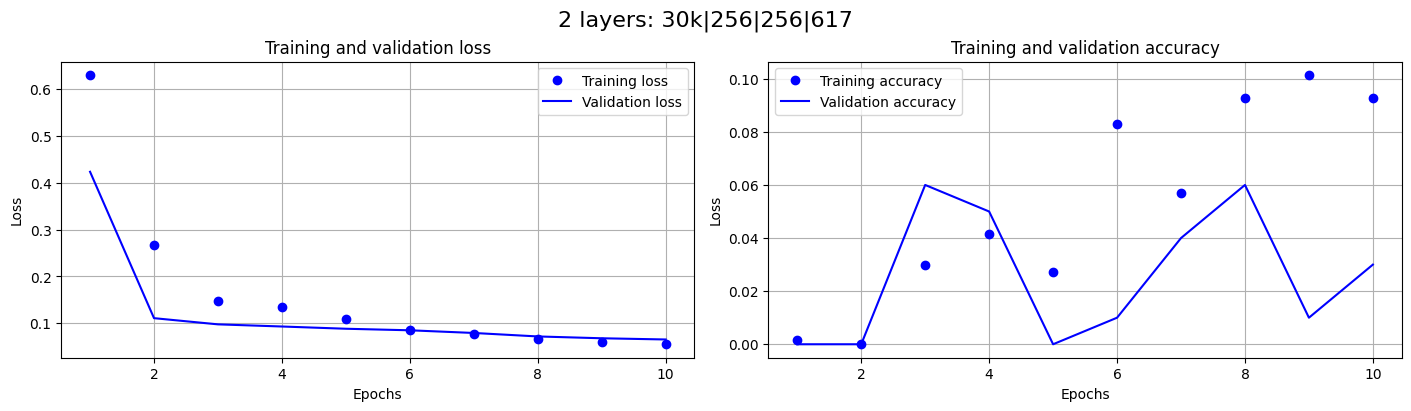

In [37]:
plot_history(history_1, title="2 layers: 30k|256|256|617")

The model can then be trained using all train data and tested again the test dataset, in order to compute its overall performances. 

In [38]:
history = model.fit(train_x, train_y,
    epochs=6,
    batch_size=128
)

Epoch 1/6
7/7 [==============================] - 0s 17ms/step - loss: 0.0534 - accuracy: 0.1275
Epoch 2/6
7/7 [==============================] - 0s 15ms/step - loss: 0.0504 - accuracy: 0.1163
Epoch 3/6
7/7 [==============================] - 0s 14ms/step - loss: 0.0476 - accuracy: 0.0913
Epoch 4/6
7/7 [==============================] - 0s 15ms/step - loss: 0.0453 - accuracy: 0.1150
Epoch 5/6
7/7 [==============================] - 0s 18ms/step - loss: 0.0432 - accuracy: 0.1375
Epoch 6/6
7/7 [==============================] - 0s 19ms/step - loss: 0.0414 - accuracy: 0.1425


In [39]:
results = model.evaluate(test_x, test_y)
results

2023-06-21 06:59:58.409833: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Incompatible shapes: [32,341] vs. [32,617]
	 [[{{node binary_crossentropy/logistic_loss/mul}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/gu/.pyenv/versions/3.11.1/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/gu/.pyenv/versions/3.11.1/lib/python3.11/asyncio/base_events.py", line 1919, in _run_once
      handle._run()
    File "/home/gu/.pyenv/versions/3.11.1/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_141827/2431662890.py", line 1, in <module>
      results = model.evaluate(test_x, test_y)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/training.py", line 2072, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/training.py", line 1852, in test_function
      return step_function(self, iterator)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/training.py", line 1836, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/training.py", line 1824, in run_step
      outputs = model.test_step(data)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/training.py", line 1790, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/losses.py", line 2156, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/gu/Workspace/jupyter-notebooks/venv/lib/python3.11/site-packages/keras/backend.py", line 5707, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/mul'
Incompatible shapes: [32,341] vs. [32,617]
	 [[{{node binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_test_function_4519]

In [23]:
predictions = model.predict(test_x)

In [32]:
[x for x in list(list(predictions)[0]) if x > 0.4]

[0.41169134]

In [1]:
test_x[0]

NameError: name 'test_x' is not defined

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560256   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1040)              267280    
                                                                 
Total params: 2,893,328
Trainable params: 2,893,328
Non-trainable params: 0
_________________________________________________________________
